## Домашнее задание
 * Выберите ряд и постройте его модель ARIMA/GARCH.
 * Не обязательное дз. Попробуйте спрогнозировать график классическим ML

In [6]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model
%matplotlib inline

In [5]:
# ! pip install arch

In [28]:
# для выполнения ДЗ возьмем изначально нестационарный ряд (так интереснее)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#Напишем ф-ю для проверки стационарности ряда и его последовательного преобразования
def check_ts(df):
    series = df.iloc[:,1]
    tsplot(series)
    dftest = adfuller(series, autolag='AIC')
    if dftest[1] < 0.05:
        print('Как мы видим, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда, ряд стационарен')
    else:
        print('Как мы видим, тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса')
        series = boxcox(series, 0)
        tsplot(series)
        dftest = adfuller(series, autolag='AIC')
        if dftest[1] < 0.05:
            print('При помощи Бокса-Кокса удалось добиться стационарности ряда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда')
        else:
            print('Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.')
            series = series[1:] - series[:-1]
            tsplot(series)
            dftest = adfuller(series, autolag='AIC')
            if dftest[1] < 0.05:
                print('При помощи дифференцирования удалось добиться стационарности ряда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда')
            else:
                print('Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее')
                lag = dftest[2]
                series = series[lag:] - series[:-lag]
                tsplot(series)
                dftest = adfuller(series, autolag='AIC')
                if dftest[1] < 0.05:
                    print('Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!')
                else:
                    print('После всех доступных преобразований ряд остался нестационарным:(')
    print('__________________________________________________________________________________________')

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Как мы видим, тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса
Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
При помощи дифференцирования удалось добиться стационарности ряда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда
__________________________________________________________________________________________


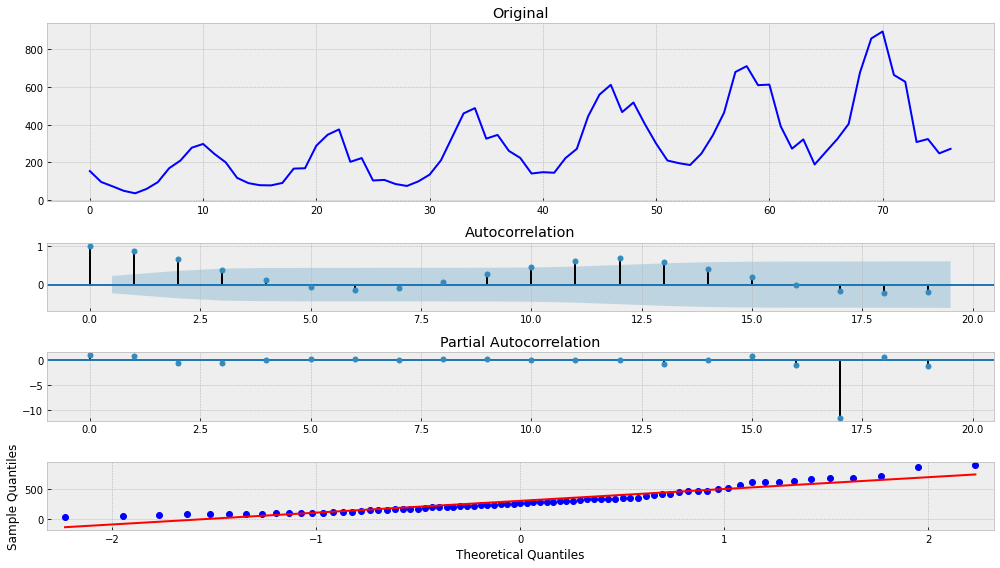

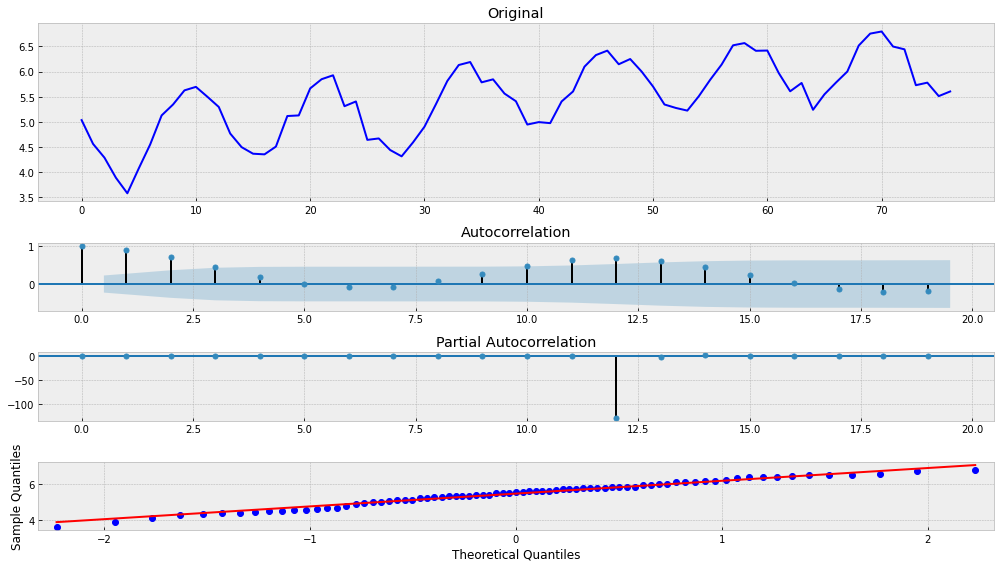

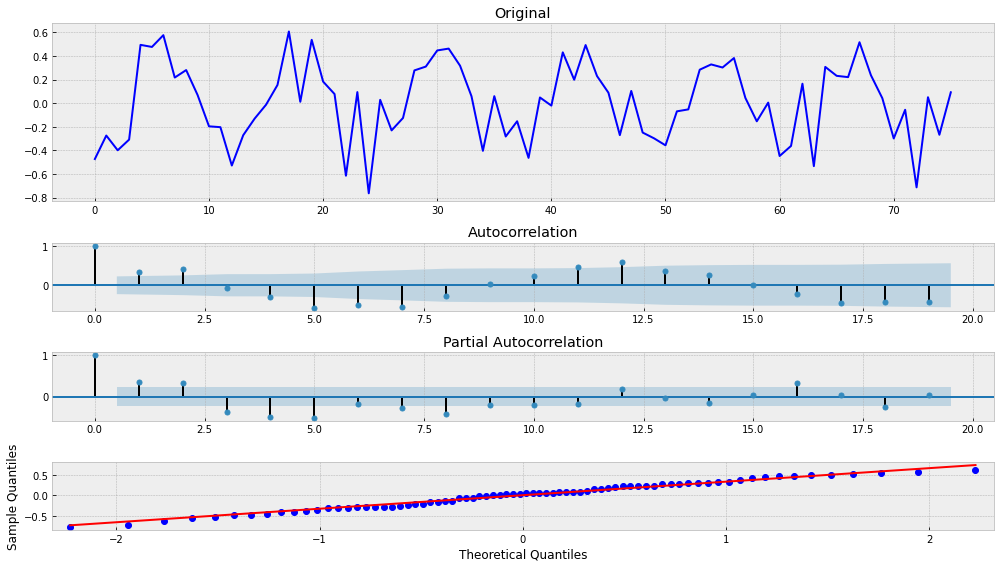

In [29]:
# Импортируем ряд из папки Series
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
check_ts(sales_of_company_x)

In [30]:
series = sales_of_company_x['Count']

In [31]:
#применим преобразование Бокса-Кокса и дифференцирование (т.к. именно с их помощью ряд приводится к стационарности см. выше):
series = boxcox(series, 0)
series = series[1:] - series[:-1]

In [42]:
#Разобьем выборку на обучающую и тестовую:
train_count = int(round(len(series)*0.9,0))
train_count
train, test = series[:train_count], series[train_count:]

C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


aic: -29.39355 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -8.707332e+00
p-value                        3.669986e-14
#Lags Used                     0.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


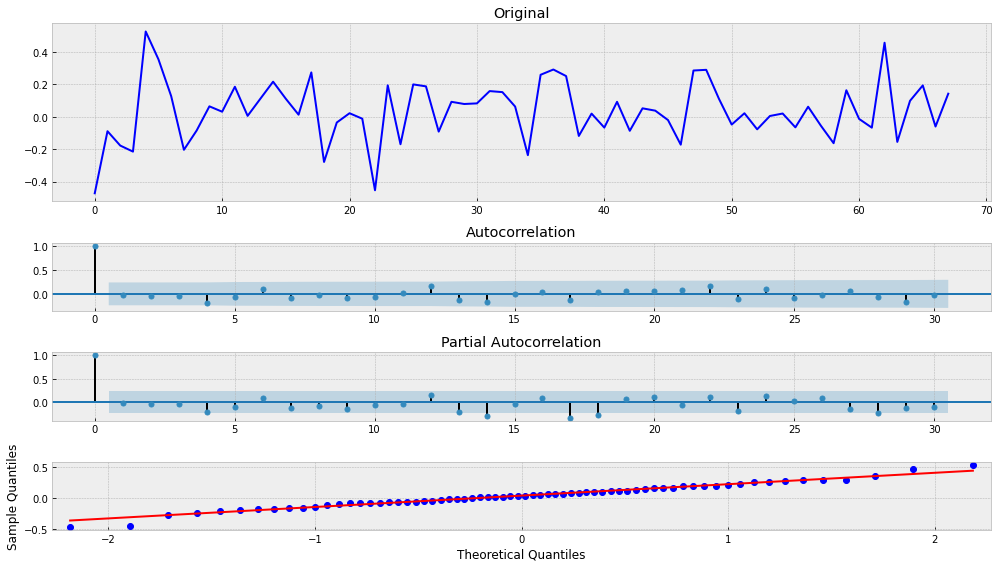

In [43]:
#Применим ARIMA на обучающей выборке
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [44]:
best_mdl

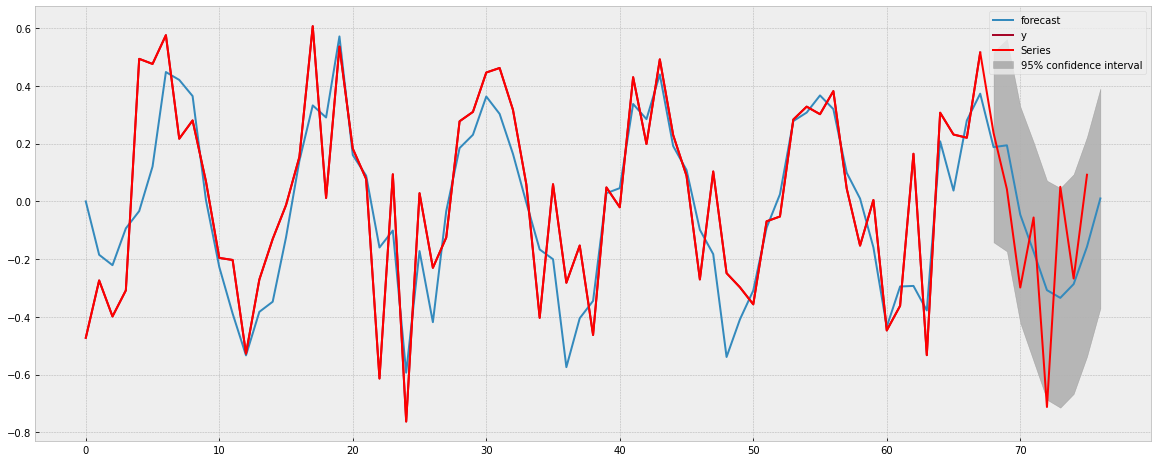

In [45]:
#Построим прогноз и посмотрим какой 95% доверительный интервал у нашей модели
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series), ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [ ]:
#Видим, что в наш 95%-ый интервал попали почти все фактические значения ряда.

In [46]:
#Применим GARCH, используя наилучшие параметры обучения ARIMA
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Используем T-критерий
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -19.9326
Distribution:      Standardized Student's t   AIC:                           55.8651
Method:                  Maximum Likelihood   BIC:                           73.6212
                                              No. Observations:                   68
Date:                      Mon, Jun 14 2021   Df Residuals:                       67
Time:                              14:33:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

Results of Dickey-Fuller Test:
Test Statistic                 -2.779650
p-value                         0.061240
#Lags Used                     11.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


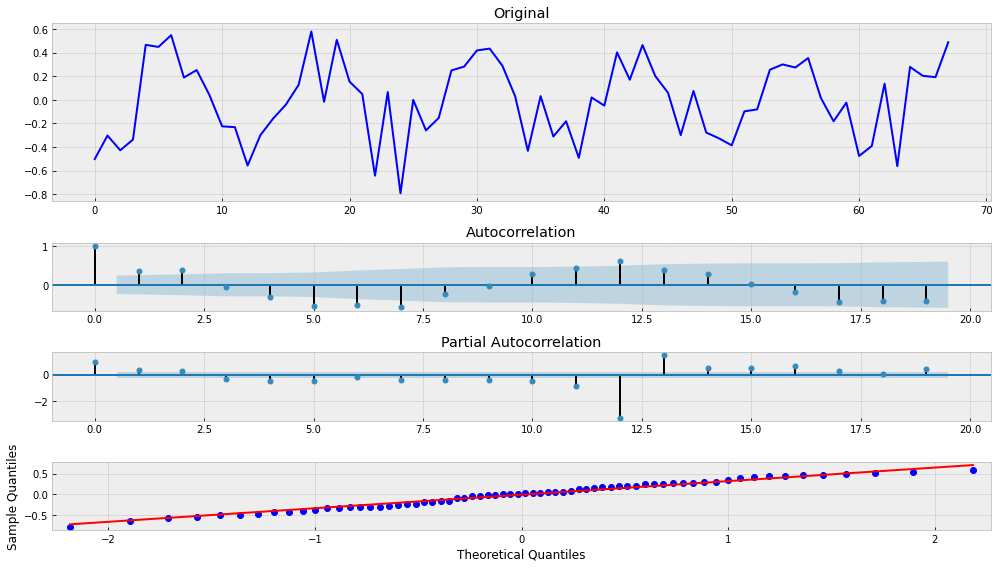

In [47]:
tsplot(res.resid)

In [58]:
#предскажем значения тестовой выборки
pred = res.forecast(horizon=len(test), method='simulation', simulations=1000)
#соединим значения обучающей выборки и прогноза для тестовой выборки
forecast = train.copy()
forecast = np.concatenate((forecast, pred.variance.values[-1, :]))

C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


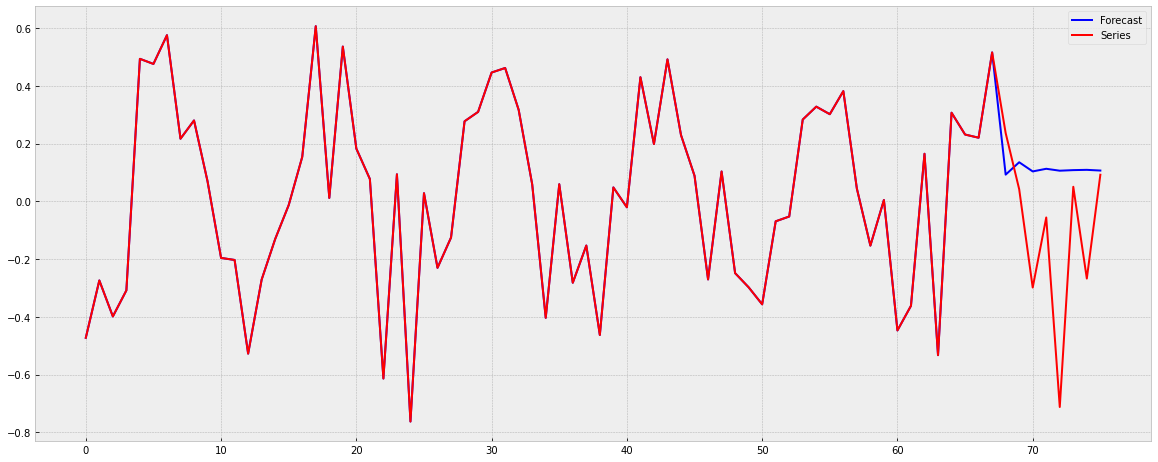

In [60]:
#Посмотрим на прогнозные и фактические значения на графике
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(forecast, color='blue', label='Forecast')
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [63]:
#Получилось очень грустно, видно, что прогноз получается отсилы на пару точек вперед и то с большими остатками. 
# Обычная ARIMA дала результат лучше:

In [64]:
#Делаем прогноз классическим ML
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [71]:
X_train, X_test, y_train, y_test = prepareData(sales_of_company_x, lag_start=1, lag_end=20, test_size=0.3)

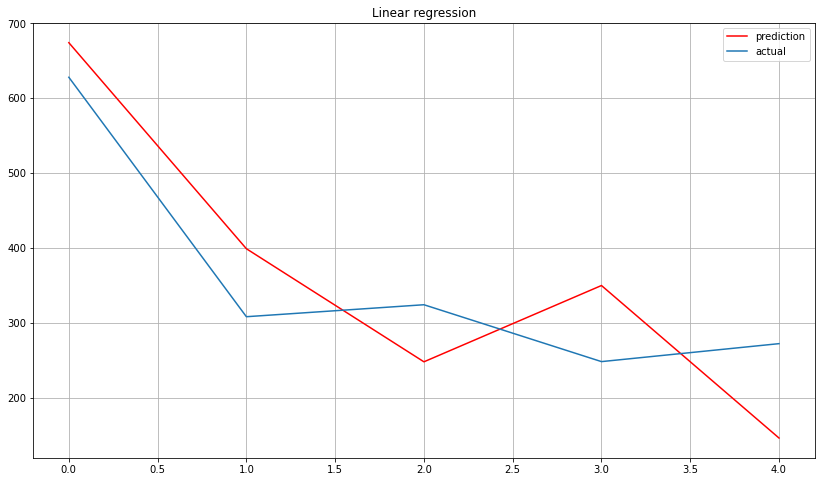

In [72]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [74]:
#Если в начале модель поймала нисходящую тенденцию тренда, то потом стала "путать" периоды роста и падения (точки 2.0, 3.0, 4.0) 